### Bridgeのアップサンプル
#### 前提条件
* トリミング画像をnew_data/からdata/crip_~に移し替えていること
* data/add_bridge/が存在していること

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms as T
import albumentations as A

In [2]:
df = pd.read_csv("csv/train_master.tsv")
label = np.array(df["flag"])

In [3]:
def inverse_lookup(d, x):
    file_name = d["file_name"]
    flag = d["flag"]
    for k, v in file_name.items():
        if x == v:
            return flag[k]
        
def make_datapath_list(root_path):
    path_list = []
    target_path = os.path.join("data" + root_path + f'/*.jpeg')
    for path in glob.glob(target_path):
        path_list.append(path)
    path_list.sort()
    path_list = [os.path.basename(p) for p in path_list]
    return path_list

In [4]:
bridge = make_datapath_list('/crip_train/bridge')
bridge_data = [Image.open('data/crip_train/bridge/' + i) for i in bridge]
bridge_label = np.array([inverse_lookup(df.to_dict(), os.path.basename(b)) for b in bridge])

In [5]:
#(224,224)でもいいのですが、モデルへの入力の選択肢を広げる意味で(448,448)にしています。
#ちゃんとモデルが決まればそのサイズにリサイズします。
size=(448,448)
bridge_resize= np.array([np.array(img.resize(size, Image.LANCZOS), dtype="uint8") for img in bridge_data])

In [6]:
class MyDataset3(torch.utils.data.Dataset):
    def __init__(self, file_list, label_list = None, P = None, A = None):
        self.P = P
        self.A = A
        self.data = file_list
        self.label = label_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.label is not None:
            label = self.label[idx]
        else:
            label = 0
        data = Image.fromarray(data)
        if self.P:
            data = self.P(data)
        if self.A:
            data = np.asarray(data)#.transpose(1,2,0)
            image = self.A(image = data)
            data = image['image']
        data = data.transpose(2,1,0)
        return data.astype(np.uint8), label

In [7]:
train_tf = T.Compose([
])
train_A = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-10,10), p=0.3),
    A.RandomRotate90(p=0.5),
])
train_set = MyDataset3(bridge_resize, bridge_label, P = train_tf, A = train_A)

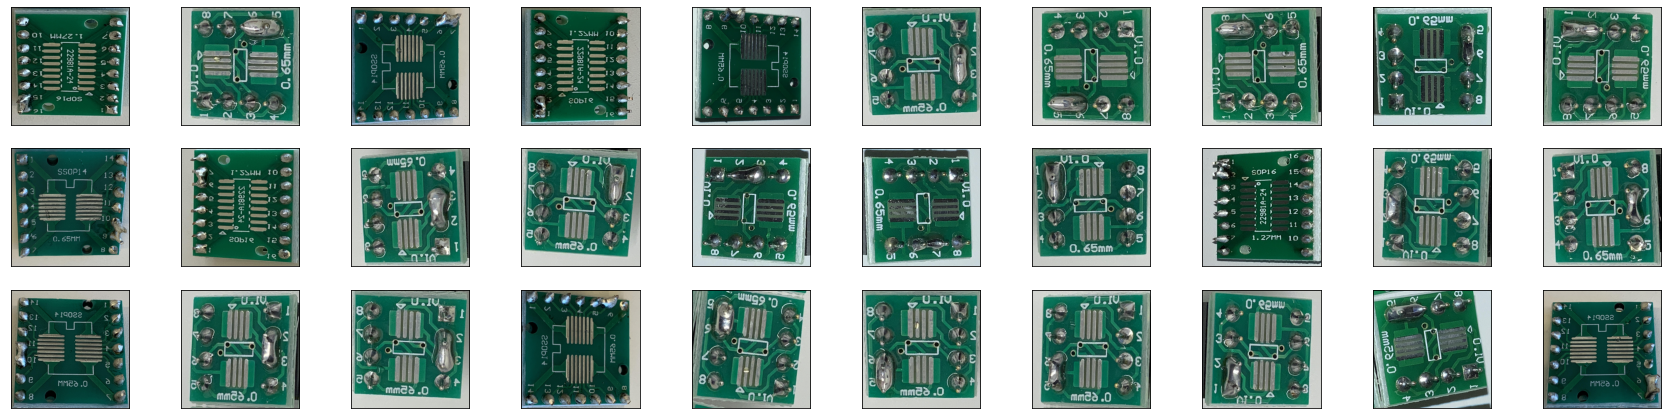

In [8]:
#結果確認
def show(k,width=30,height=10):
    plt.figure(figsize=(width, height))
    for i in range(len(k)):
        plt.subplot(4, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(k[i],vmin=0,vmax=255)
    plt.show()
    return
train_aug = np.array([t[0].transpose(1,2,0) for t in train_set])
show(train_aug[:40])

### 60枚水増し

In [12]:
for i,t in enumerate(train_aug):
    image = Image.fromarray(t)
    zero_i = "{0:03d}".format(i)
    #image.save(f"data/add_bridge/bridge_{zero_i}.jpeg")
    image.save(f"data/add_bridge/s_bridge_{zero_i}.jpeg")